In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import gc, sys, os, timeit
%matplotlib inline
fig_size = [0,0]
fig_size[0] = 20
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams['font.sans-serif'] = ['simhei'] 
plt.rcParams['font.size'] = 22
plt.rcParams['font.weight'] = 'bold'

In [2]:
TIME = 183 # 一個購物週期3個月
UNIT_RECENT_COUNT_THREDSHOLD = 10
SEASON_COUNT = 6

In [3]:
def time(worker):
    tick = timeit.default_timer()
    ret = worker()
    tock = timeit.default_timer()
    eclipse = tock-tick
    print('In %r:\n Spent %f sec'%(worker, eclipse))
    return eclipse, ret

## Loading...

In [4]:
df_member = pd.read_csv('../Member.csv')
df_ecoupon = pd.read_csv('../ECoupon.csv')
df_promotion = pd.read_csv('../PromotionOrders.csv')
df_main = pd.read_csv('../Orders.csv')

D:\andyl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
D:\andyl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df_member['MinOrderDate'].value_counts()

2016-11-11    2462
2016-07-08    2008
2016-11-13    1987
2016-09-28    1852
2016-09-27    1809
2016-04-10    1805
2016-07-09    1624
2016-03-20    1604
2016-03-06    1596
2016-11-12    1579
2016-07-10    1561
2016-07-06    1476
2016-07-07    1445
2015-10-12    1432
2017-11-11    1428
2016-11-14    1371
2017-11-12    1365
2016-03-19    1365
2016-03-13    1363
2016-07-14    1342
2016-03-16    1337
2016-04-09    1333
2016-11-10    1320
2016-03-07    1308
2016-07-15    1250
2016-04-02    1248
2016-04-21    1237
2015-12-06    1237
2016-07-11    1232
2016-03-17    1228
              ... 
2015-05-20      74
2015-06-03      74
2017-01-24      74
2018-02-10      73
2018-02-16      73
2015-05-22      70
2015-06-09      67
2015-05-29      63
2015-05-28      58
2018-02-14      58
2018-02-15      47
2015-06-02      42
2018-02-11      42
2015-05-26      39
2018-02-12      38
2015-05-27      33
2015-05-16      27
2015-05-10      25
2015-05-09      24
2015-05-17      22
2015-05-11      20
2015-05-12  

## 抓出給定長度的資料

In [6]:
df_main['Date'] = pd.to_datetime(df_main['DateId'].astype(str), format='%Y%m%d')

In [7]:
t_begin = df_main['Date'].min()
t_range = pd.Timedelta(TIME, unit='d')
print(t_begin)

2015-05-06 00:00:00


In [8]:
df_main.drop(labels='DateId', inplace=True, axis=1)
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5495276 entries, 0 to 5495275
Data columns (total 28 columns):
MemberId                       int64
OrderGroupCode                 object
TrackSourceTypeDef             object
TrackDeviceTypeDef             object
PayProfileTypeDef              object
SalesOrderSlaveId              int64
SalePageId                     int64
IsMajor                        bool
IsGift                         bool
IsSalePageGift                 bool
Quantity                       int64
UnitPrice                      float64
PromotionDiscount              float64
ECouponId                      int64
ECouponDiscount                float64
SalesOrderSlaveTotalPayment    float64
SalesOrderSlaveDateTime        object
SalesOrderReceiverId           int64
City                           object
District                       object
ZipCode                        float64
StoreName                      object
StoreId                        object
DeliverTypeDef      

In [9]:
df_mains = {}
for i in range(SEASON_COUNT):
    df_mains[i] = \
        df_main[df_main['Date'] < t_begin + t_range * (i + 1)]\
        [df_main['Date'] >= t_begin + t_range * i]


D:\andyl\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
PR_DROP=['PromotionId', 'SalesOrderSlavePromotionDiscount',
       'SalesOrderSlavePromotionDiscountAllocated',
       'SalesOrderSlavePromotionDiscountAllocatedQty',
       'SalesOrderSlavePromotionDiscountRate',
       'PromotionCondition_DiscountPrice', 'PromotionCondition_DiscountRate',
       'PromotionCondition_TotalPrice', 'PromotionCondition_TotalQty',
       'PromotionStartDateTime', 'PromotionEndDateTime']
df_promotion.drop(PR_DROP,axis=1,inplace=True,errors='ignore')
df_promotion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4011064 entries, 0 to 4011063
Data columns (total 2 columns):
SalesOrderSlaveId    int64
DiscountType         object
dtypes: int64(1), object(1)
memory usage: 61.2+ MB


In [11]:
EC_DROP=['ECouponStartDateTime',
       'ECouponEndDateTime', 'ECouponUsingStartDateTime',
       'ECouponUsingEndDateTime', 'ECouponDiscountPrice',
       'ECouponMaxDiscountLimit']
df_ecoupon.drop(EC_DROP,axis=1,inplace=True,errors='ignore')
df_ecoupon.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 2 columns):
ECouponId         261 non-null int64
ECouponTypeDef    261 non-null object
dtypes: int64(1), object(1)
memory usage: 4.2+ KB


## Merge Data

In [12]:
for k in df_mains:
    df_mains[k] = df_mains[k].merge(df_ecoupon, on='ECouponId', how='left')
    df_mains[k] = df_mains[k].merge(df_promotion, on='SalesOrderSlaveId', how='left')
    gc.collect()

# 顧客分群 
## 由一季內的單次平均購買 vs 購買次數 進行客群劃分 
   - 分成五群 
       - 流失的客戶 0 vs 0
       

**統計單次消費總額**

In [13]:
main_by_baskets = {}
for k in df_mains:
    main_by_baskets[k] = df_mains[k]\
        .groupby(by=['OrderGroupCode','MemberId'], as_index=False)\
            ['SalesOrderSlaveTotalPayment']\
        .sum()
    print(main_by_baskets[k].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98999 entries, 0 to 98998
Data columns (total 3 columns):
OrderGroupCode                 98999 non-null object
MemberId                       98999 non-null int64
SalesOrderSlaveTotalPayment    98999 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 219893 entries, 0 to 219892
Data columns (total 3 columns):
OrderGroupCode                 219893 non-null object
MemberId                       219893 non-null int64
SalesOrderSlaveTotalPayment    219893 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 309513 entries, 0 to 309512
Data columns (total 3 columns):
OrderGroupCode                 309513 non-null object
MemberId                       309513 non-null int64
SalesOrderSlaveTotalPayment    309513 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 9

### 計算每位會員平均單次消費額
- 用於計算客戶的季度總消費額

In [14]:
def rename_col_to(name, old, new):
    if name == old:
        return new
    else:
        return name
    
member_avgs = {}
for k in df_mains:
    member_avgs[k] = main_by_baskets[k]\
        .groupby(by='MemberId', as_index=False)\
        .agg('mean')
    member_avgs[k].rename(
        columns = lambda r: rename_col_to(r, 'SalesOrderSlaveTotalPayment', 'RecentAveragePurchase'),
        inplace=True)
    print(member_avgs[k].head())

   MemberId  RecentAveragePurchase
0      1329                  306.0
1      1372                  125.0
2      1373                  448.0
3      1423                  373.0
4      1469                  585.0
   MemberId  RecentAveragePurchase
0      1334             333.000000
1      1373             143.714286
2      1384             557.000000
3      1391             593.000000
4      1393             199.000000
   MemberId  RecentAveragePurchase
0      1326             249.000000
1      1336           12473.000000
2      1373             282.666667
3      1384             590.000000
4      1448            1056.000000
   MemberId  RecentAveragePurchase
0      1362                  591.0
1      1400                  798.0
2      1469                  813.0
3      1474                 1618.0
4      1514                  698.0
   MemberId  RecentAveragePurchase
0      1384                  721.0
1      1448                 1678.0
2      1663                 1596.0
3      1787         

**統計客戶的季度總消費額**

In [15]:
member_purchase_cnts = {}
for k in df_mains:
    member_purchase_cnts[k] = main_by_baskets[k]\
        .groupby(by='MemberId', as_index=False)\
        .agg('count')
    print(member_purchase_cnts[k].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69883 entries, 0 to 69882
Data columns (total 3 columns):
MemberId                       69883 non-null int64
OrderGroupCode                 69883 non-null int64
SalesOrderSlaveTotalPayment    69883 non-null int64
dtypes: int64(3)
memory usage: 2.1 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 139516 entries, 0 to 139515
Data columns (total 3 columns):
MemberId                       139516 non-null int64
OrderGroupCode                 139516 non-null int64
SalesOrderSlaveTotalPayment    139516 non-null int64
dtypes: int64(3)
memory usage: 4.3 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 192916 entries, 0 to 192915
Data columns (total 3 columns):
MemberId                       192916 non-null int64
OrderGroupCode                 192916 non-null int64
SalesOrderSlaveTotalPayment    192916 non-null int64
dtypes: int64(3)
memory usage: 5.9 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 159637 entries, 0 t

In [16]:
member_purchase_medians = {}
member_purchase_averages = {}
for k in df_mains:
    member_avgs[k]['RecentCount'] = member_purchase_cnts[k]['OrderGroupCode']
    member_avgs[k]['RecentTotal'] = member_avgs[k]['RecentCount'] * member_avgs[k]['RecentAveragePurchase']
    member_purchase_medians[k] = member_avgs[k]['RecentAveragePurchase'].median()
    member_purchase_averages[k] = member_avgs[k]['RecentAveragePurchase'].mean()
    print(member_avgs[k].head())
    print(member_purchase_medians[k])

   MemberId  RecentAveragePurchase  RecentCount  RecentTotal
0      1329                  306.0            3        918.0
1      1372                  125.0            2        250.0
2      1373                  448.0            1        448.0
3      1423                  373.0            1        373.0
4      1469                  585.0           11       6435.0
694.0
   MemberId  RecentAveragePurchase  RecentCount  RecentTotal
0      1334             333.000000            3        999.0
1      1373             143.714286            7       1006.0
2      1384             557.000000            1        557.0
3      1391             593.000000            1        593.0
4      1393             199.000000            1        199.0
720.0
   MemberId  RecentAveragePurchase  RecentCount  RecentTotal
0      1326             249.000000            1        249.0
1      1336           12473.000000            1      12473.0
2      1373             282.666667            3        848.0
3      1384 

**印出各購買次數的會員平均單次購買金額的落點**

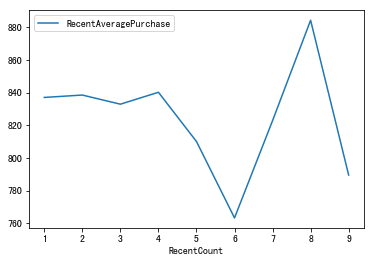

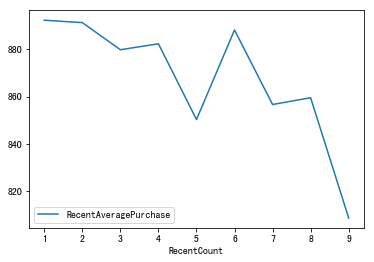

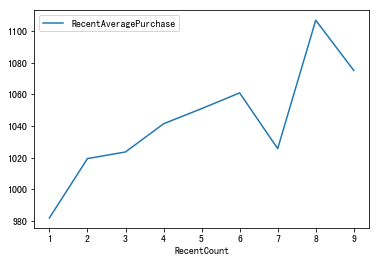

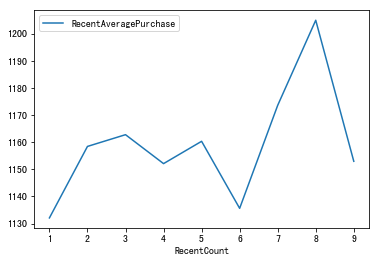

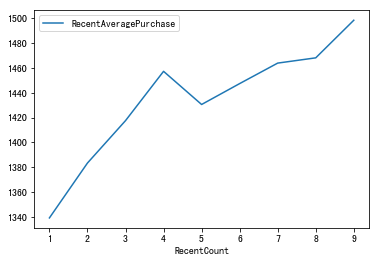

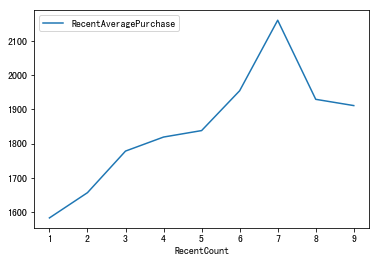

In [17]:
for k in df_mains:
    tmp0 = member_avgs[k]\
        .groupby(by=['RecentCount'], as_index=False)\
            ['RecentAveragePurchase']\
        .mean()
    tmp0[tmp0['RecentCount'] < UNIT_RECENT_COUNT_THREDSHOLD]\
        .plot.line(x='RecentCount', y='RecentAveragePurchase')
    plt.show()
    gc.collect()


## 把各顧客分群並標上標記

In [18]:
RecentCount_threshold = 2

In [19]:
df_member_news = {}
for k in df_mains:
    df_member_news[k] = df_member.merge(member_avgs[k], how='left')

In [20]:
for k in df_mains:
    df_member_news[k][~np.isnan(df_member_news[k]['RecentAveragePurchase'])]

In [21]:
def set_member_group(row, axis_th_x = RecentCount_threshold, axis_th_y = 0, axis_key_x = 'RecentCount', axis_key_y = 'RecentAveragePurchase'):
    value = 0
    if not np.isnan(row[axis_key_x]) and row[axis_key_x] < axis_th_x:
        if row[axis_key_y] < axis_th_y:
            value = 3
        else:
            value = 2
    elif not np.isnan(row[axis_key_x]):
        if row[axis_key_y] < axis_th_y:
            value = 4
        else:
            value = 1
    
    return value

for k in df_mains:
    df_member_news[k]['MemberGroup'] = \
        df_member_news[k].apply(lambda r: set_member_group(r, RecentCount_threshold, member_purchase_medians[k]), axis = 1)
    #    parallel_apply(df_members[k], set_member_group, RecentCount_threshold, member_purchase_medians[k])
    

In [22]:
statistics = {}
for k in df_mains:
    statistics[k] = pd.DataFrame()
    statistics[k]['MemberCount'] = df_member_news[k]\
        .groupby(by='MemberGroup')['MemberId']\
        .agg(['count'])['count']


             MemberCount
MemberGroup             
0                 789613
1                   9037
2                  25812
3                  26738
4                   7946
             MemberCount
MemberGroup             
0                 720249
1                  22660
2                  46935
3                  50177
4                  19125
             MemberCount
MemberGroup             
0                 666289
1                  34433
2                  62078
3                  70484
4                  25862
             MemberCount
MemberGroup             
0                 699517
1                  28098
2                  51747
3                  58387
4                  21397
             MemberCount
MemberGroup             
0                 701585
1                  28329
2                  50473
3                  57938
4                  20821
             MemberCount
MemberGroup             
0                 728426
1                  23764
2                  41645


In [23]:
for k in df_mains:
    statistics[k]['TotalSales'] = df_member_news[k].groupby(by='MemberGroup')['RecentTotal'].agg(['sum'])['sum']

             MemberCount  TotalSales
MemberGroup                         
0                 789613         0.0
1                   9037  27791727.0
2                  25812  31830527.0
3                  26738  12218521.0
4                   7946  10450889.0
             MemberCount  TotalSales
MemberGroup                         
0                 720249         0.0
1                  22660  77016376.0
2                  46935  60930429.0
3                  50177  25834609.0
4                  19125  29869414.0
             MemberCount   TotalSales
MemberGroup                          
0                 666289          0.0
1                  34433  143128177.0
2                  62078   93142711.0
3                  70484   37040396.0
4                  25862   40246081.0
             MemberCount   TotalSales
MemberGroup                          
0                 699517          0.0
1                  28098  130690562.0
2                  51747   88663696.0
3                  58387  

In [24]:
for k in df_mains:
    statistics[k].index = ['潛水客', '高消熟客','低消熟客','低消新客','高消新客']
    print(statistics[k])

      MemberCount  TotalSales
潛水客        789613         0.0
高消熟客         9037  27791727.0
低消熟客        25812  31830527.0
低消新客        26738  12218521.0
高消新客         7946  10450889.0
      MemberCount  TotalSales
潛水客        720249         0.0
高消熟客        22660  77016376.0
低消熟客        46935  60930429.0
低消新客        50177  25834609.0
高消新客        19125  29869414.0
      MemberCount   TotalSales
潛水客        666289          0.0
高消熟客        34433  143128177.0
低消熟客        62078   93142711.0
低消新客        70484   37040396.0
高消新客        25862   40246081.0
      MemberCount   TotalSales
潛水客        699517          0.0
高消熟客        28098  130690562.0
低消熟客        51747   88663696.0
低消新客        58387   36020372.0
高消新客        21397   39996139.0
      MemberCount   TotalSales
潛水客        701585          0.0
高消熟客        28329  169920078.0
低消熟客        50473  109670191.0
低消新客        57938   35496797.0
高消新客        20821   37659559.0
      MemberCount   TotalSales
潛水客        728426          0.0
高消熟客        23764  1

## 觀察各期消費分群人數的變遷

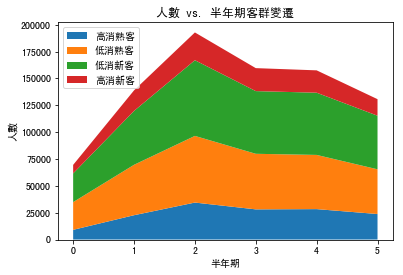

In [25]:
df_group_count = pd.DataFrame()
for k in df_mains:
    df_group_count = df_group_count.append(
        df_member_news[k]['MemberGroup'].value_counts().transpose(),
        ignore_index = True
    )
    
plt.stackplot(
    list(range(0, max(df_mains) + 1)), 
    df_group_count.loc[:, 1:4].transpose(), 
    labels=['高消熟客', '低消熟客', '低消新客', '高消新客'])
plt.legend(loc='upper left')
plt.title('人數 vs. 半年期客群變遷')
plt.xticks(np.arange(0, max(df_mains) + 1, 1.0))
plt.xlabel('半年期')
plt.ylabel('人數')
plt.show()

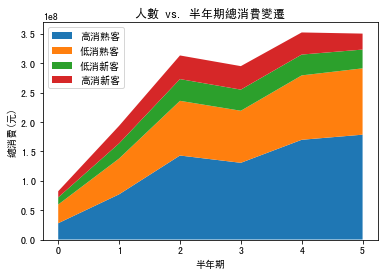

In [26]:
df_group_purchase = pd.DataFrame()
for k in df_mains:
    basket_sum = main_by_baskets[k].groupby('MemberId', as_index=False)['SalesOrderSlaveTotalPayment'].sum()
    member_sum = df_member_news[k].merge(basket_sum, on='MemberId', how='left')
    group_sum = member_sum.groupby('MemberGroup')['SalesOrderSlaveTotalPayment'].sum()
    df_group_purchase = df_group_purchase.append(
        group_sum.transpose(), ignore_index = True
    )
    
plt.stackplot(
    list(range(0, max(df_mains) + 1)), 
    df_group_purchase.loc[:, 1:].transpose(), #排除無消費的人 因為無意義
    labels=['高消熟客', '低消熟客', '低消新客', '高消新客'])
plt.legend(loc='upper left')
plt.title('人數 vs. 半年期總消費變遷')
plt.xticks(np.arange(0, max(df_mains) + 1, 1))
plt.xlabel('半年期')
plt.ylabel('總消費(元)')
plt.show()

## 優惠使用人群

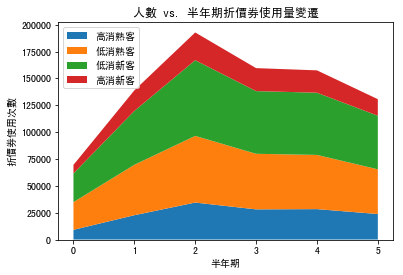

In [123]:
df_ecoupon_group = pd.DataFrame()
for k in df_mains:
    df_with_ecoupon = df_mains[k][df_mains[k]['ECouponTypeDef'].fillna('') != '']
    df = df_with_ecoupon.groupby('MemberId', as_index=False)['ECouponTypeDef'].count()
    df.columns = ['MemberId', 'ECouponCount']
    df = df_member_news[k].merge(df, on='MemberId', how='left')
    df = df.groupby('MemberGroup')['MemberId'].count()
    df.columns = ['MemberGroup', 'ECouponCounappendt']
    df_ecoupon_group = df_ecoupon_group.append(df.transpose(), ignore_index = True)
    
plt.stackplot(
    list(range(0, max(df_mains) + 1)), 
    df_ecoupon_group.loc[:, 1:].transpose(), #排除無消費的人 因為無意義
    labels=['高消熟客', '低消熟客', '低消新客', '高消新客'])
plt.legend(loc='upper left')
plt.title('人數 vs. 半年期折價券使用量變遷')
plt.xticks(np.arange(0, max(df_mains) + 1, 1))
plt.xlabel('半年期')
plt.ylabel('折價券使用次數')
plt.show()

## 個別折扣使用量

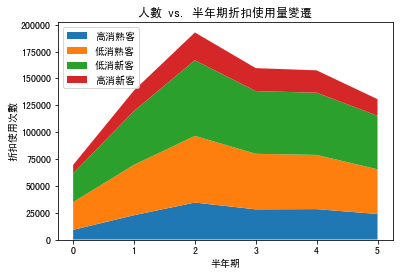

In [124]:
df_discount_group = pd.DataFrame()
for k in df_mains:
    df_with_discount = df_mains[k][df_mains[k]['DiscountType'].fillna('') != '']
    df = df_with_discount.groupby('MemberId', as_index=False)['DiscountType'].count()
    df.columns = ['MemberId', 'DiscountCount']
    df = df_member_news[k].merge(df, on='MemberId', how='left')
    df = df.groupby('MemberGroup')['MemberId'].count()
    df.columns = ['MemberGroup', 'DiscountCount']
    df_discount_group = df_discount_group.append(df.transpose(), ignore_index = True)
    
plt.stackplot(
    list(range(0, max(df_mains) + 1)), 
    df_discount_group.loc[:, 1:].transpose(), #排除無消費的人 因為無意義
    labels=['高消熟客', '低消熟客', '低消新客', '高消新客'])
plt.legend(loc='upper left')
plt.title('人數 vs. 半年期折扣使用量變遷')
plt.xticks(np.arange(0, max(df_mains) + 1, 1))
plt.xlabel('半年期')
plt.ylabel('折扣使用次數')
plt.show()

## 觀察熱銷物品的會員分群

In [135]:
MAX_BEST_SELLING = 20
max_counts_s = {}
counts = {}
for k in df_mains:
    counts[k] = df_mains[k][df_mains[k]['IsMajor']]['SalePageId'].value_counts(sort=True)
    max_counts_s[k] = counts[k].index[0:MAX_BEST_SELLING]
    max_counts_s[k]

In [136]:
df_in_best_sellings = {}
for k in df_mains:
    df_in_best_sellings[k] = df_mains[k][df_mains[k]['SalePageId'].isin(max_counts_s[k])]

In [137]:
[df_member_news[k].info() for k in df_mains if True]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 859146 entries, 0 to 859145
Data columns (total 13 columns):
MemberId                   859146 non-null int64
Birthday                   237275 non-null object
GenderTypeDef              237276 non-null object
RegisterSourceTypeDef      829143 non-null object
RegisterDateTime           859146 non-null object
MinOrderDate               562300 non-null object
OpenCardPresent            859146 non-null int64
LastBirthdayPresentYear    859146 non-null int64
IsInBlackList              1004 non-null object
RecentAveragePurchase      69533 non-null float64
RecentCount                69533 non-null float64
RecentTotal                69533 non-null float64
MemberGroup                859146 non-null int64
dtypes: float64(3), int64(4), object(6)
memory usage: 131.8+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 859146 entries, 0 to 859145
Data columns (total 13 columns):
MemberId                   859146 non-null int64
Birthday             

[None, None, None, None, None, None]

In [138]:
for k in df_mains:
    df_in_best_sellings[k] = df_in_best_sellings[k].merge(
        df_member_news[k].loc[:, ['MemberId', 'MemberGroup']],
        on='MemberId',
    )
    df_in_best_sellings[k].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47397 entries, 0 to 47396
Data columns (total 31 columns):
MemberId                       47397 non-null int64
OrderGroupCode                 47397 non-null object
TrackSourceTypeDef             47397 non-null object
TrackDeviceTypeDef             47397 non-null object
PayProfileTypeDef              47397 non-null object
SalesOrderSlaveId              47397 non-null int64
SalePageId                     47397 non-null int64
IsMajor                        47397 non-null bool
IsGift                         47397 non-null bool
IsSalePageGift                 47397 non-null bool
Quantity                       47397 non-null int64
UnitPrice                      47397 non-null float64
PromotionDiscount              47397 non-null float64
ECouponId                      47397 non-null int64
ECouponDiscount                47397 non-null float64
SalesOrderSlaveTotalPayment    47397 non-null float64
SalesOrderSlaveDateTime        47397 non-null obje

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133214 entries, 0 to 133213
Data columns (total 31 columns):
MemberId                       133214 non-null int64
OrderGroupCode                 133214 non-null object
TrackSourceTypeDef             133214 non-null object
TrackDeviceTypeDef             133214 non-null object
PayProfileTypeDef              133214 non-null object
SalesOrderSlaveId              133214 non-null int64
SalePageId                     133214 non-null int64
IsMajor                        133214 non-null bool
IsGift                         133214 non-null bool
IsSalePageGift                 133214 non-null bool
Quantity                       133214 non-null int64
UnitPrice                      133214 non-null float64
PromotionDiscount              133214 non-null float64
ECouponId                      133214 non-null int64
ECouponDiscount                133214 non-null float64
SalesOrderSlaveTotalPayment    133214 non-null float64
SalesOrderSlaveDateTime        1

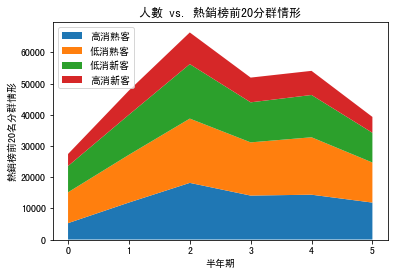

In [139]:
hottest_by_group = pd.DataFrame()
for k in df_mains:
    uniq_members = df_in_best_sellings[k]['MemberId'].unique()
    by_group = df_member_news[k][
        df_member_news[k]['MemberId']\
        .isin(uniq_members)
    ]['MemberGroup'].value_counts(ascending=True)
    hottest_by_group = hottest_by_group.append(by_group.transpose(), ignore_index=True)
    
plt.stackplot(
    list(range(0, max(df_mains) + 1)), 
    hottest_by_group.loc[:, 1:].transpose(), #排除無消費的人 因為無意義
    labels=['高消熟客', '低消熟客', '低消新客', '高消新客'])
plt.legend(loc='upper left')
plt.title('人數 vs. 熱銷榜前%i分群情形'%MAX_BEST_SELLING)
plt.xticks(np.arange(0, max(df_mains) + 1, 1))
plt.xlabel('半年期')
plt.ylabel('熱銷榜前%i名分群情形'%MAX_BEST_SELLING)
plt.show()

Year: 0
Year: 1
Year: 2
Year: 3
Year: 4
Year: 5


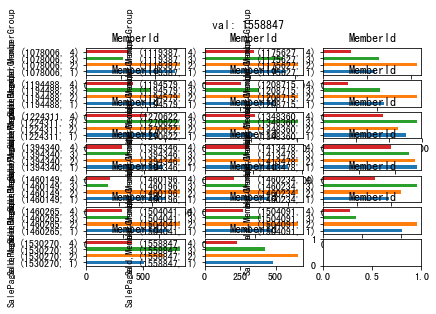

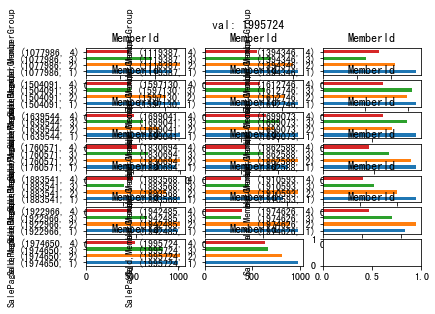

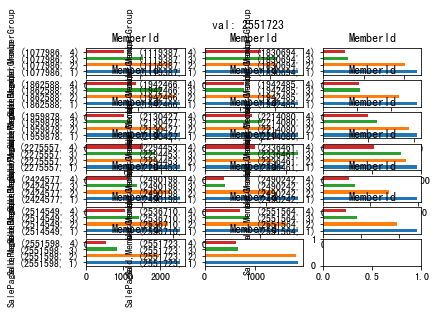

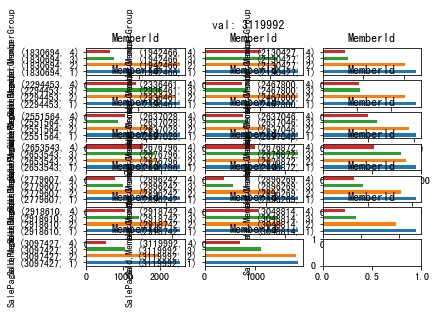

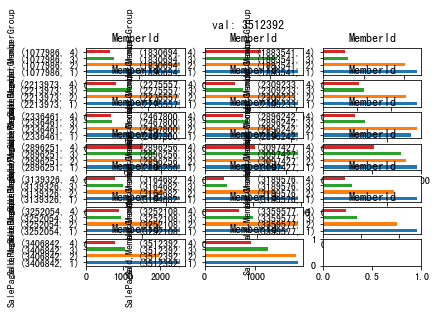

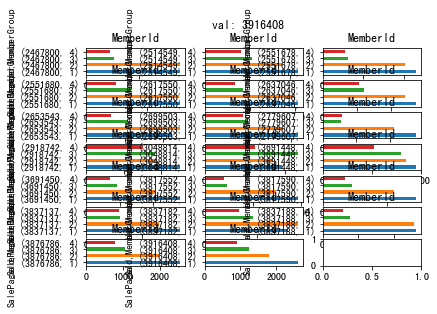

In [140]:
member_groups_by_hottest_items_s = {}
gs = {}
for k in df_mains: 
    member_groups_by_hottest_items_s[k] =\
        df_in_best_sellings[k].groupby(by=['SalePageId', 'MemberGroup']).count()['MemberId']
    member_groups_by_hottest_items_s[k].columns = ['MemberGroup', 'Counts']
    gs[k] = member_groups_by_hottest_items_s[k].groupby('SalePageId')
    fig, axes = plt.subplots(nrows=7, ncols=3)
    print('Year: {}'.format(k))
    for it in gs:
        i = 0
        for val, group in gs[it]:
            group.plot.barh(subplots=True, ax=axes[i//3, i%3], title = 'val: {}'.format(val))
            i += 1

Year: 0
Year: 1
Year: 2
Year: 3
Year: 4
Year: 5


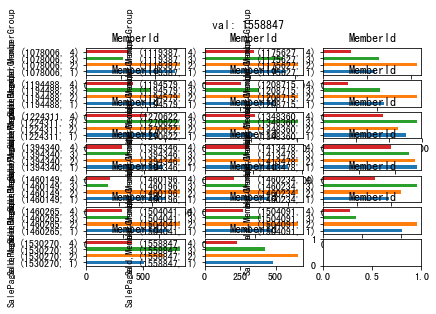

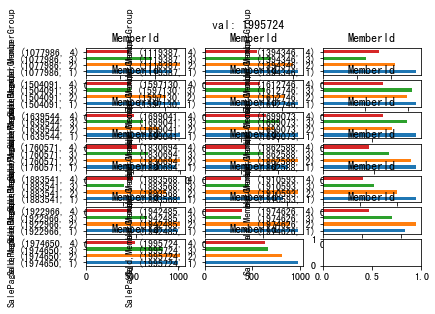

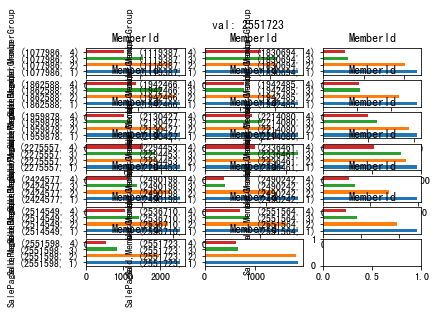

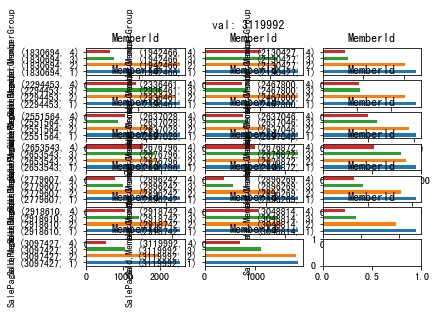

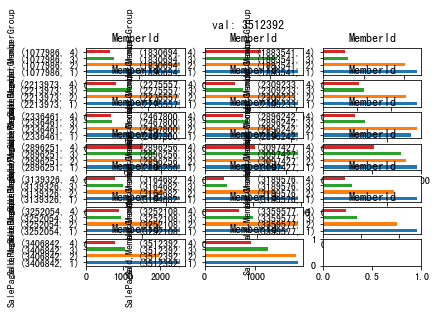

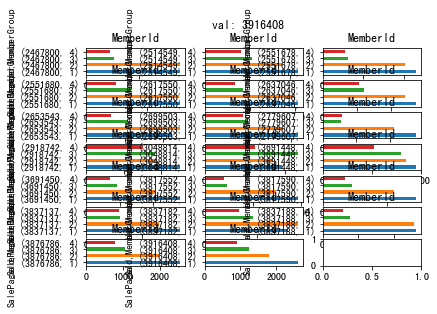

In [141]:
member_groups_by_hottest_items_s = {}
gs = {}
for k in df_mains: 
    member_groups_by_hottest_items_s[k] =\
    df_in_best_sellings[k].groupby(by=['SalePageId', 'MemberGroup']).count()['MemberId']
    member_groups_by_hottest_items_s[k].columns = ['MemberGroup', 'Counts']
    gs[k] = member_groups_by_hottest_items_s[k].groupby('SalePageId')
    fig, axes = plt.subplots(nrows=7, ncols=3)
    print('Year: {}'.format(k))
    for it in gs:
        i = 0
        for val, group in gs[it]:
            group.plot.barh(subplots=True, ax=axes[i//3, i%3], title = 'val: {}'.format(val))
            i += 1

## 買熱門商品下一季/年客群的轉換

In [35]:
df_next_group = {}
for k in df_mains:
    if k == max(df_mains): 
        break
    df_next_group[k] = pd.DataFrame()
    
    current_members = df_in_best_sellings[k]['MemberId'].unique()
    # 當季客群分布: 先萃取當前使用者清單，再查看對應的群組
    df_next_group[k]['Current'] =\
        df_member_news[k][ #由訂單為單位的資料轉換到有購買的客戶列表
            df_member_news[k]['MemberId'].isin(current_members)
        ]['MemberGroup']\
        .value_counts(sort=False, ascending = True)
        
    # 由本季使用者清單，在下季的member資訊檢索下季的客戶分群
    df_next_group[k]['Next'] =\
        df_member_news[k+1][
            df_member_news[k+1]['MemberId'].isin(current_members)
        ]['MemberGroup'].value_counts(sort=False, ascending = True)
        
        
    print('\nYear %i'%k)
    print(df_next_group[k])


Year 0
   Current  Next
1     5253  2564
2     9893  2341
3     8425  2187
4     3849  1796

Year 1
   Current  Next
1    11865  5731
2    15304  4802
3    12844  4102
4     7754  3269

Year 2
   Current  Next
1    18164  6283
2    20607  5761
3    17472  5169
4    10149  3751

Year 3
   Current  Next
1    14094  5760
2    17055  5348
3    12841  3944
4     7929  2611

Year 4
   Current  Next
1    14376  5033
2    18409  5071
3    13560  3755
4     7736  1987
